## Notebook #1b in the simulation series

This is purely for validation and does not produce new dataproducts needed for other notebooks.

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import AltAz, EarthLocation, SkyCoord
from astropy.time import Time
import astropy.units as u
import healpy as hp
from pygdsm import GlobalSkyModel16

%matplotlib widget

In [2]:
d = np.load("data_models.npz")

data = np.ma.array(d["data"], mask=d["mask"])
times = d["times"]
freqs = d["freqs"]  # MHz
beam_alm = d["beam_alm"]  # beam alm model
beam_hp = d["beam_hp"]  # healpix map of the alm model
g_rx = d["g_rx"]  # receiver gain (mean of beam factored out)

BEAM_NSIDE = hp.get_nside(beam_hp[0])
print(BEAM_NSIDE)
BEAM_NPIX = hp.nside2npix(BEAM_NSIDE)

tx_flux = np.load("../sim_v003.npz")["tx_flux"][0]

16


In [3]:
overwrite_sky = False
sky_path = Path("sky_topo.npy")
if overwrite_sky or not sky_path.exists():
    new_sky = True
else:
    new_sky = False
    sky_topo = np.load(sky_path)

In [4]:
# pixel centers for topocentric hp grid
theta_topo, phi_topo = hp.pix2ang(BEAM_NSIDE, np.arange(BEAM_NPIX))
  
alt_topo = np.pi/2 - theta_topo
alt_topo = alt_topo * u.rad
az_topo  = phi_topo * u.rad

if new_sky:
    gsm = GlobalSkyModel16(freq_unit="MHz", data_unit="TRJ", resolution="lo", include_cmb=True)
    gsm_map = gsm.generate(freqs)
    hp.mollview(gsm_map[0])
    
    gsm_nside = hp.get_nside(gsm_map[0])
    gsm_npix = len(gsm_map[0])
    gal_lon, gal_lat = hp.pix2ang(gsm_nside, np.arange(gsm_npix), lonlat=True)
    
    LAT = 39.247699
    LON = -113.402660
    HGT = 1800 # m
    
    loc = EarthLocation(LON, LAT, HGT)
    obstimes = Time(times, format="jd")
    altaz = [AltAz(location=loc, obstime=t) for t in obstimes]

    
    # transform to altaz
    sky_topo = np.empty((len(times), len(freqs), BEAM_NPIX), dtype=np.float32)
    for i, topo_frame in enumerate(altaz):
        sc_altaz = SkyCoord(alt=alt_topo, az=az_topo, frame=topo_frame)
        sc_gal = sc_altaz.transform_to("galactic")
        
        # nearest-neighbor interpolation
        pix = hp.ang2pix(gsm_nside, sc_gal.l.value, sc_gal.b.value, lonlat=True)
        sky_topo[i, :, :] = gsm_map[:, pix]

    np.save(sky_path, sky_topo)

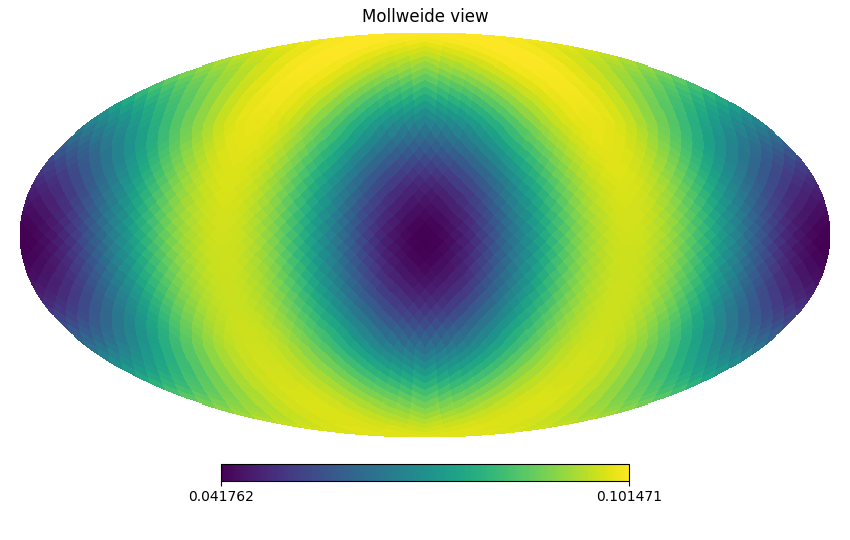

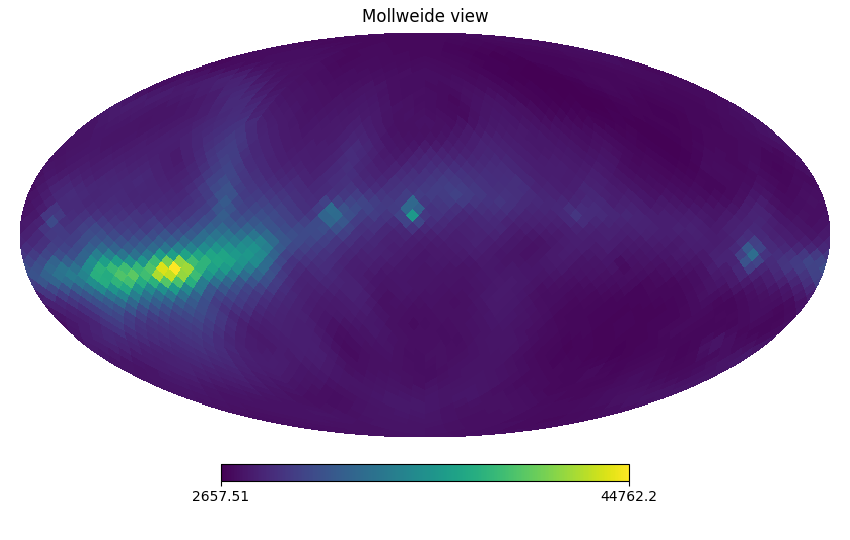

In [5]:
hp.mollview(beam_hp[0])
plt.show()

hp.mollview(sky_topo[0, 0])
plt.show()

## Multiply sky with beam

In [46]:
beam_npix

768

In [6]:
# basic (and wrong) horizon profile
horizon = np.ones(BEAM_NPIX, dtype=int)  # 1s above horizon
horizon[alt_topo.value < 0] = 0  # 0s below horizon

# assign some ground temp and receiver temp
t_gnd = 300
t_rx = 75

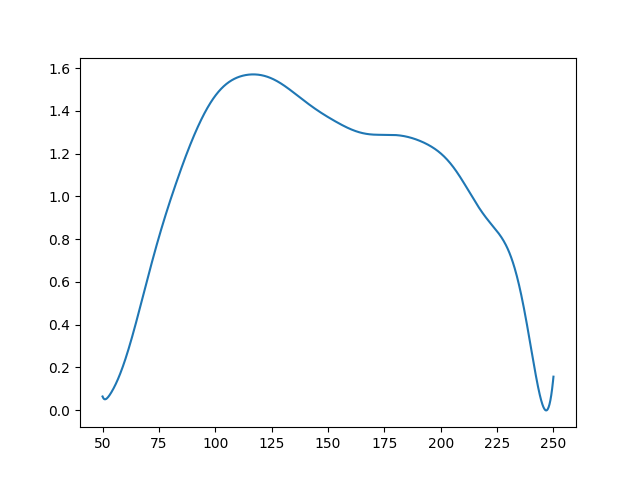

In [24]:
plt.figure()
plt.plot(freqs, sky_topo[0].mean(axis=-1) * g_rx / 1e4)
plt.show()

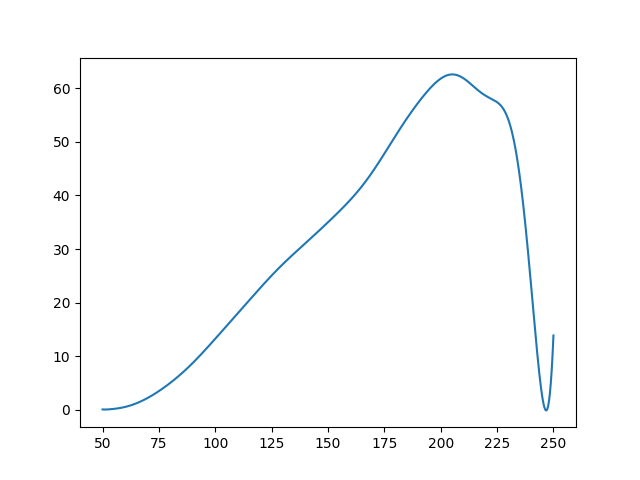

In [20]:
plt.figure()
plt.plot(freqs, g_rx)
plt.show()

In [18]:
def sim(sky, beam, horizon, g_rx, t_gnd, t_rx, tx_flux=None):
    """
    Simulation at a single time and single orienation of the box, assuming everything has been rotated to the world frame.
    Beam is assumed to be normalized so it integrates to 1.
    If tx_flux is given, add a transmitter directly below the antenna

    shapes:
    sky = (nfreq, npix)
    beam = (nfreq, npix)
    horizon = (npix)
    g_rx = (nfreq)
    t_gnd = scalar
    t_rx = scalar
    tx_flux = (nfreq)
    """
    gnd_pix = (horizon == 0)
    print(np.sum(gnd_pix) / len(gnd_pix))
    sim_sky = sky.copy()
    sim_sky[:, gnd_pix] = t_gnd
    dA = 4*np.pi / len(horizon)
    if tx_flux is not None:
        sim_sky[:, -1] += tx_flux / dA
    t_ant = g_rx * np.sum(sim_sky * beam * dA, axis=1) + t_rx
    if tx_flux is None:
        return t_ant
    # mask the same way as the data if tx is on
    tx_mask = np.zeros(len(sky), dtype=bool)
    tx_mask[::16] = True
    return np.ma.array(t_ant, mask=tx_mask)

In [33]:
#t_ant = sim(sky_topo[0], beam_hp, horizon, G_rx, 3000, 100)
t_ant = sim(sky_topo[0], beam_hp, horizon, 1e4*g_rx, 300, 100, tx_flux=tx_flux/1e4)
t_ant0 = sim(np.zeros_like(sky_topo[0]), beam_hp, np.ones_like(horizon), 1e4*g_rx, 0, 0, tx_flux=tx_flux/1e4)

0.4895833333333333
0.0


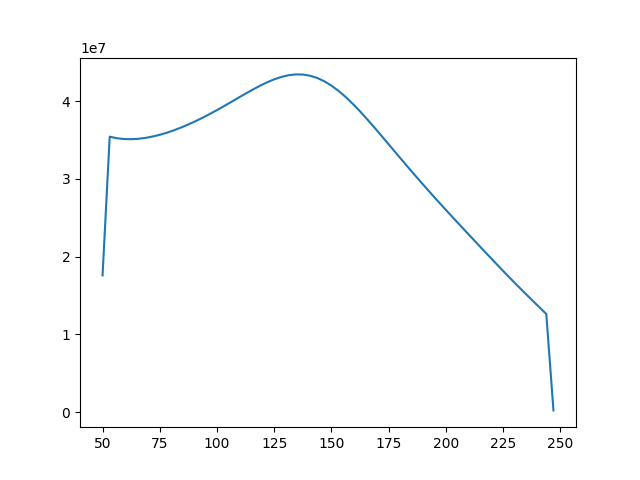

In [39]:
plt.figure()
plt.plot(freqs[::16], (data.data[0, 0, ::16] - 1e2) / (2*g_rx[::16]))
plt.show()

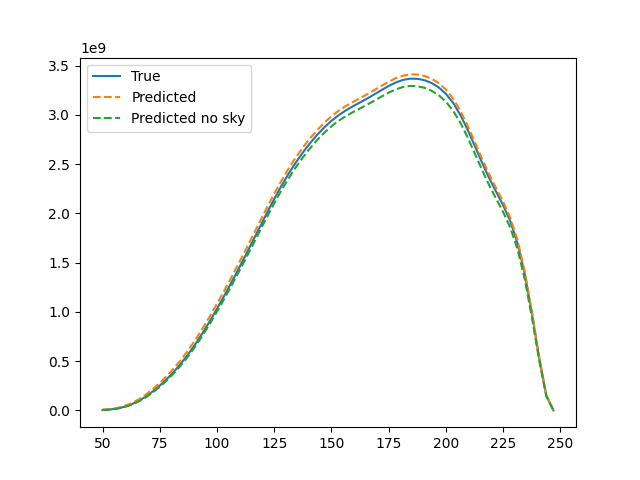

In [34]:
plt.figure()
plt.plot(freqs[::16], data.data[0, 0, ::16], label="True")
plt.plot(freqs[::16], t_ant.data[::16], label="Predicted", ls="--")
plt.plot(freqs[::16], t_ant0.data[::16], label="Predicted no sky", ls="--")
plt.legend()
plt.show()

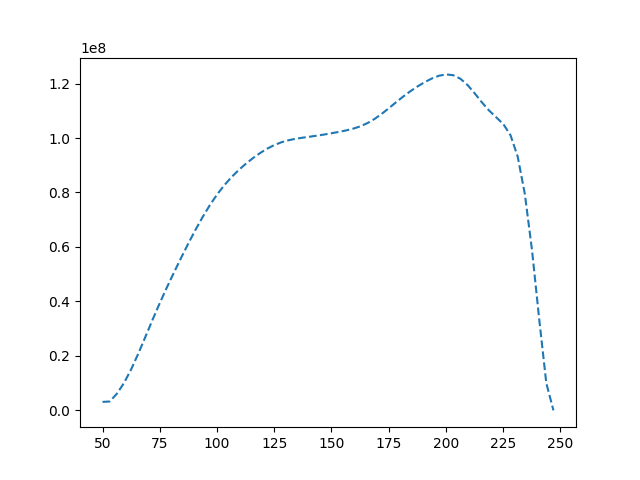

In [35]:
plt.figure()
plt.plot(freqs[::16], (t_ant.data[::16] - t_ant0.data[::16]), label="Predicted", ls="--")
#plt.legend()
#plt.yscale("log")
plt.show()

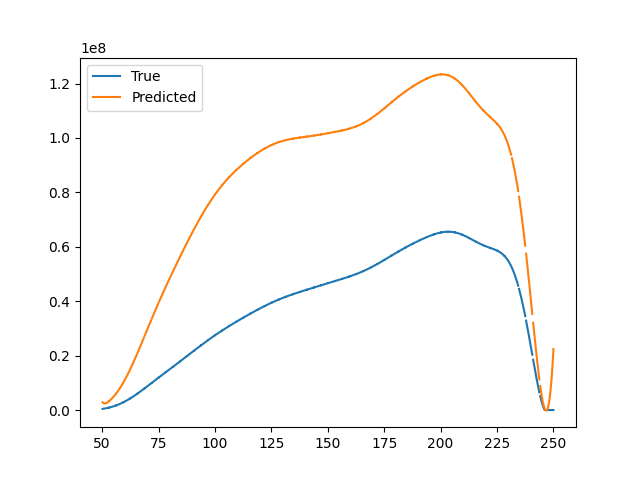

In [36]:
plt.figure()
plt.plot(freqs, data[0, 0], label="True")
plt.plot(freqs, t_ant, label="Predicted")
plt.legend()
#plt.yscale("log")
plt.show()

In [78]:
def tx_predict(tx_flux, g_rx, t_rx, t_gnd)

plt.figure()
plt.plot(G_

(1024,)